In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

In [2]:
companies = ['CVX', 'AAPL', 'MSFT', 'GOOG']
ticker = companies[0]
start_date = '2000-01-01'
end_date = '2024-01-01'

In [3]:
df = yf.download(ticker, start=start_date, end=end_date)
df.columns = df.columns.droplevel('Ticker')
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price       Adj Close     Close      High       Low      Open   Volume
Date                                                                  
2000-01-03  16.611204  41.81250  42.93750  41.28125  42.93750  4387600
2000-01-04  16.611204  41.81250  42.06250  41.25000  41.46875  3702400
2000-01-05  16.909159  42.56250  43.28125  41.53125  41.53125  5567600
2000-01-06  17.629234  44.37500  44.59375  42.65625  42.65625  4353400
2000-01-07  17.939608  45.15625  45.43750  44.50000  45.00000  4487400


In [4]:
window_size = 60
guess_size = 1
train_end_year = 2018
validation_end_year = 2022

In [5]:
def process_df(df: pd.DataFrame, window_size, guess_size):
    # fill in NaNs
    df = df.copy()
    df = df.bfill()
    df = df.drop(columns=['Volume'])

    # difference data
    first = df.iloc[0]
    differenced = df.diff().dropna()

    # split into windows
    close = differenced['Close'].to_numpy()
    differenced = differenced.drop(columns=['Close']).to_numpy()

    X = []
    y = []
    index = 0
    while index < len(differenced) - window_size - guess_size:
        X.append(differenced[index: index + window_size])
        y.append(close[index + window_size: index + window_size + guess_size])
        index += 7

    X = torch.tensor(np.array(X), dtype=torch.float32)
    y = torch.tensor(np.array(y), dtype=torch.float32)
    return X, y, first



train = df[df.index.year <= train_end_year]
validation = df[(df.index.year > train_end_year) & (df.index.year <= validation_end_year)]
test = df[df.index.year > validation_end_year]

X_train, y_train, train_first = process_df(train, window_size, guess_size)
X_validation, y_validation, validation_first = process_df(validation, window_size, guess_size)
X_test, y_test, test_first = process_df(test, window_size, guess_size)

# X_combined = pd.concat([X_train, X_validation])
# y_combined = pd.concat([y_train, y_validation])

In [6]:
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        last_time_step = out[:, -1, :]
        predictions = self.fc(last_time_step)
        return predictions

In [7]:
hidden_dim = 128
num_layers = 3
dropout = 0.3
lr = 0.0001
epochs = 100
loss = torch.nn.MSELoss()
batch_size = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTM(
    input_dim=4,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    output_dim=guess_size,
    dropout=dropout
)
model = model.to(device)

100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


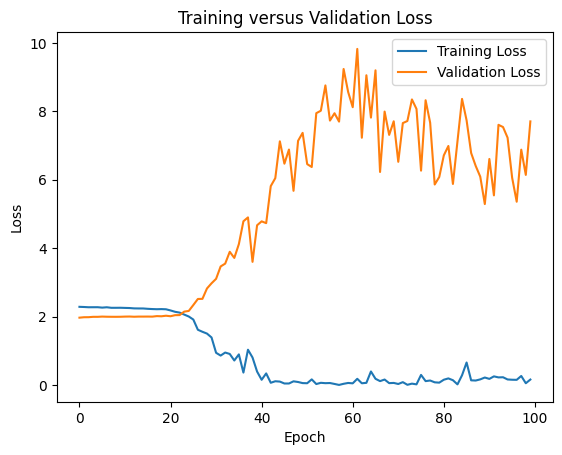

In [8]:
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
model = model.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

X_validation = X_validation.to(device)
y_validation = y_validation.to(device)

validation_dataset = TensorDataset(X_validation, y_validation)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

training_loss = []
validation_loss = []
for t in tqdm(range(epochs)):

    for X_batch, y_batch in train_loader:
      # zero out gradients
      optimiser.zero_grad()

      # train model
      y_train_pred = model(X_batch)
      loss_val = loss(y_train_pred, y_batch)
      loss_val.backward()
      optimiser.step()
    training_loss.append(loss_val.item())

    for X_batch, y_batch in validation_loader:
      y_val_pred = model(X_batch)
      loss_val = loss(y_val_pred, y_batch)

    validation_loss.append(loss_val.item())

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.title("Training versus Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [9]:
# train on validation
for t in tqdm(range(epochs)):
  for X_batch, y_batch in train_loader:
      # zero out gradients
      optimiser.zero_grad()

      # train model
      y_train_pred = model(X_batch)
      loss_val = loss(y_train_pred, y_batch)
      loss_val.backward()
      optimiser.step()

100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


Money Gained: -6.189%
Marked Lost: -13.052%


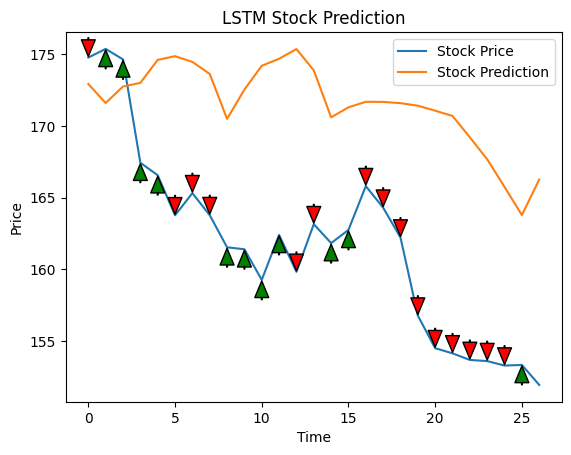

In [10]:
X_test = X_test.to(device)
y_pred_final = model(X_test).squeeze().cpu().detach().numpy()

y_test_series = np.array(y_test.squeeze()).cumsum() + test_first['Close']
y_pred_final = y_pred_final.cumsum() + test_first['Close']

# calculate money earned
money_start = 10000
money = money_start
buy = []
sell = []
for i in range(len(y_pred_final) - 1):
  if y_pred_final[i] <= y_pred_final[i + 1]:
    buy.append(i)
    money += money * ((y_test_series[i + 1] - y_test_series[i]) / y_test_series[i])
  else:
    sell.append(i)


plt.plot(y_test_series, label="Stock Price")
plt.plot(y_pred_final, label="Stock Prediction")
# Add green arrows for buy signals
for i in range(len(buy)):
    plt.annotate('', xy=(buy[i], y_test_series[buy[i]]), xytext=(0, -15),
                 textcoords='offset points', ha='center', color='green',
                 arrowprops=dict(facecolor='green', shrink=0.05, width=0.5, headwidth=10))

# Add red arrows for sell signals
for i in range(len(sell)):
    plt.annotate('', xy=(sell[i], y_test_series[sell[i]]), xytext=(0, 15),
                 textcoords='offset points', ha='center', color='red',
                 arrowprops=dict(facecolor='red', shrink=0.05, width=0.5, headwidth=10))

plt.legend()
plt.title("LSTM Stock Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
print(f"Money Gained: {(money - money_start)/money_start * 100:.3f}%")
print(f"Market Lost: {(y_test_series[-1] - y_test_series[0]) / y_test_series[0] * 100:.3f}%")

plt.show()